In [ ]:
# !pip install fastai2

# Exploring TS definitions...

In [ ]:
#export
from fastcore.test import *
from fastai2.basics import *
from fastai2.torch_core import *
from fastai2.data import *

In [ ]:
#export
import pandas as pd
from fastcore.all import *
from scipy.io import arff

# Core

> Basic timeseries opening/processing funcs.

In [ ]:
#export
def maybe_unsqueeze(x):
    "Add empty dimension if it is a rank 1 tensor/array"
    if isinstance(x, np.ndarray): return x[None,:] if len(x.shape)==1 else x
    if isinstance(x, Tensor): return x.unsqueeze(0) if len(x.shape)==1 else x
    else: return None

In [ ]:
a = np.random.random(10)
test_eq((1,10), maybe_unsqueeze(a).shape)
test_eq((1,10), maybe_unsqueeze(maybe_unsqueeze(a)).shape) #do nothing

t = torch.rand(10)
test_eq((1,10), maybe_unsqueeze(t).shape)
test_eq((1,10), maybe_unsqueeze(maybe_unsqueeze(t)).shape) #do nothing

A time series is just an array of 1 dimesion.

In [ ]:
#export
def show_array(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    # Handle pytorch axis order
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = maybe_unsqueeze(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-'+c,label=label, **kwargs)
    if title is not None: ax.set_title(title)
    ax.legend()
    return ax

A simple array of 1 channel is `np.arange(10)`.

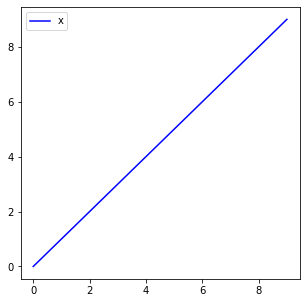

In [ ]:
show_array(np.arange(10));

In [ ]:
# export
class TSeries(TensorBase):
    "Basic Timeseries wrapper"  
    @classmethod
    def create(cls, x): 
        return cls(maybe_unsqueeze(x))
    
    @property
    def channels(self): return self.shape[0]
    
    @property
    def len(self): return self.shape[-1]
    
    def __repr__(self):
        return f'TSeries(ch={self.channels}, len={self.len})'
    
    def show(self, ctx=None, **kwargs):
        return show_array(self, ctx=ctx, **kwargs)

## TESTS

In [ ]:
X = np.random.rand(10000, 1000)
y = np.random.randint(0,10,10000)

## Loading from arrays:

In [ ]:
class NaiveNumpyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __getitem__(self, idx):
        if self.y is None: return (self.X[idx], )
        else: return (self.X[idx], self.y[idx])

    def __len__(self):
        return len(self.X)

In [ ]:
ds = NaiveNumpyDataset(X,y)

In [ ]:
ds.X.shape, ds.y.shape

((10000, 1000), (10000,))

In [ ]:
dls_torch = torch.utils.data.DataLoader(dataset=ds, batch_size=8)

In [ ]:
dls = DataLoaders.from_dsets(ds, bs=8)

In [ ]:
def cycle_dl(dl):
    for x,y in iter(dl):
        pass

In [ ]:
bx,by = dls.train.one_batch()
bx.shape

torch.Size([64, 1000])

In [ ]:
%timeit cycle_dl(dls_torch)

67.4 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit cycle_dl(dls.train)

430 ms ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
class NumpyDataset():
    "Tensor aware implementation"
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __getitem__(self, idx):
        if self.y is None: return (self.X[idx], )
        else: return (TSeries.create(self.X[idx]), TensorCategory(self.y[idx]))

    def __len__(self):
        return len(self.X)

In [ ]:
ds = NumpyDataset(X,y)

In [ ]:
ds[0]

(TSeries(ch=1, len=1000), TensorCategory(9))

In [ ]:
dls = DataLoaders.from_dsets(ds, bs=8)

In [ ]:
dls.train.one_batch()

(TSeries(ch=64, len=1000),
 TensorCategory([0, 7, 8, 5, 8, 2, 0, 4, 3, 5, 4, 0, 6, 1, 2, 0, 2, 0, 1, 3, 8, 5, 2, 1,
         0, 6, 2, 2, 7, 4, 8, 9, 6, 1, 0, 2, 8, 4, 0, 6, 5, 3, 1, 4, 9, 5, 9, 5,
         7, 5, 5, 5, 1, 7, 9, 8, 2, 2, 6, 2, 9, 9, 2, 8]))

In [ ]:
%timeit cycle_dl(dls.train)

500 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
class TSTransform(Transform):
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def encodes(self, i):
        return (TSeries.create(self.x[i]), TensorCategory(self.y[i]))

In [ ]:
tl = TfmdLists(range_of(X), TSTransform(X, y))

In [ ]:
tl[0:5]

(#5) [(TSeries(ch=1, len=1000), TensorCategory(9)),(TSeries(ch=1, len=1000), TensorCategory(4)),(TSeries(ch=1, len=1000), TensorCategory(4)),(TSeries(ch=1, len=1000), TensorCategory(2)),(TSeries(ch=1, len=1000), TensorCategory(3))]

In [ ]:
dls = DataLoaders.from_dsets(tl, bs=8)

In [ ]:
bx, by = dls.one_batch()

In [ ]:
%timeit cycle_dl(dls.train)

588 ms ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
dl =TfmdDL(tl, bs=8)

In [ ]:
%timeit cycle_dl(dl)

1.32 s ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## batch tfmdDL

In [ ]:
class Slicer:
    "slice numpy ds"
    def __init__(self,to): self.to = to
    def __getitem__(self, idxs):
        return self.to.new(*self.to[idxs])

class NumpyDataset2():
    def __init__(self, X, y=None):
        self.X, self.y = X, y

    def __getitem__(self, idx):
        if self.y is None: return (self.X[idx], )
        else: return (self.X[idx], self.y[idx])

    def __len__(self):
        return len(self.X)

    @property
    def slicer(self):
        return Slicer(self)

    def new(self, X, y):
        return type(self)(X, y)

In [ ]:
ds = NumpyDataset2(X,y)

In [ ]:
ds.slicer[0:4]

In [ ]:
class ReadTSBatch(ItemTransform):
    def __init__(self, to): self.to = to

    def encodes(self, to):
        res = (tensor(to.X).float(), )
        res = res + (tensor(to.y),)
        # if to.device is not None: res = to_device(res, to.device)
        return res

    # def decodes(self, o):
    #     o = [_maybe_expand(o_) for o_ in to_np(o) if o_.size != 0]
    #     vals = np.concatenate(o, axis=1)
    #     try: df = pd.DataFrame(vals, columns=self.to.all_col_names)
    #     except: df = pd.DataFrame(vals, columns=self.to.x_names)
    #     to = self.to.new(df)
    #     return to

In [ ]:
rtb = ReadTSBatch(ds) 
rtb.encodes(ds.slicer[0:4])

(tensor([[0.6450, 0.5591, 0.4961,  ..., 0.9510, 0.9956, 0.3058],
         [0.5910, 0.5129, 0.3756,  ..., 0.5563, 0.6508, 0.7463],
         [0.7334, 0.8890, 0.8533,  ..., 0.5777, 0.7604, 0.9337],
         [0.6739, 0.5046, 0.5792,  ..., 0.6419, 0.6893, 0.3760]]),
 tensor([9, 4, 4, 2]))

In [ ]:
class TSDataloader(TfmdDL):
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms)+ReadTSBatch(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.slicer[b]

In [ ]:
dl = TSDataloader(ds, bs=128)

In [ ]:
%timeit cycle_dl(dl)

20.5 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
